In [58]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats

sns.set()
my_palette = sns.color_palette("husl")
my_palette.pop(1)
sns.set_palette(sns.color_palette(my_palette))

## Data Exploration

In [45]:
data = pd.read_csv("data/452 25:03:20.csv")
print(data.shape)
data.head()

(5697, 6)


,arrived,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
0,True,Silverthorne Road,2020-03-11 09:52:37,20191_490012162E_2020-03-11_out_0,2020-03-11 09:52:12,out
1,True,Notting Hill Gate Station,2020-03-11 14:27:25,20190_490000167G_2020-03-11_out_0,2020-03-11 14:27:10,out
2,True,Kilburn Lane / Harrow Road,2020-03-19 10:32:23,20190_490007860N_2020-03-19_out_0,2020-03-19 10:31:09,out
3,True,Sopwith Way,2020-03-10 10:00:51,20191_490G00012235_2020-03-10_in_0,2020-03-10 09:56:47,in
4,True,Sheffield Terrace,2020-03-10 10:10:28,20203_490012055N_2020-03-10_in_0,2020-03-10 10:09:23,in


In [46]:
data = data.drop(columns = "arrived")
print(data['bus_stop_name'].unique())
print(len(data['bus_stop_name'].unique()))

['Silverthorne Road' 'Notting Hill Gate Station'
 'Kilburn Lane / Harrow Road' 'Sopwith Way' 'Sheffield Terrace'
 'Sloane Street / Knightsbridge Station' 'Larkhall Park' 'Lister Hospital'
 'Banister Road' 'Chesterton Road' 'Stanley Gardens'
 'Vauxhall Bus Station' 'Ladbroke Road'
 'Sloane Square Stn  / Lower Sloane St' 'Kensington Palace'
 'Battersea Park Station' 'Prairie Street' 'Union Road'
 'Queenstown Road / Wandsworth Road' 'The Chase' 'Knightsbridge Station'
 'Kensal House' 'York House Place / Kensington High St'
 "Ladbroke Grove Sainsbury's" 'Knightsbridge Barracks' 'Pont Street'
 'Station Terrace' 'Wandsworth Road Station' 'Royal Hospital Chelsea'
 'Palace Gate' 'Sloane Street / Sloane Square Station'
 'Ladbroke Grove Station' 'Rutland Gardens' 'Barlby Road'
 'Exhibition Road' 'Lansdowne Green' 'Knightsbridge Station  / Harrods'
 'Portobello and Golborne Market' 'Battersea Park / Chelsea Gate'
 'Kensington Church Street / Holland St' 'Covent Garden Market East Side'
 'Queensto

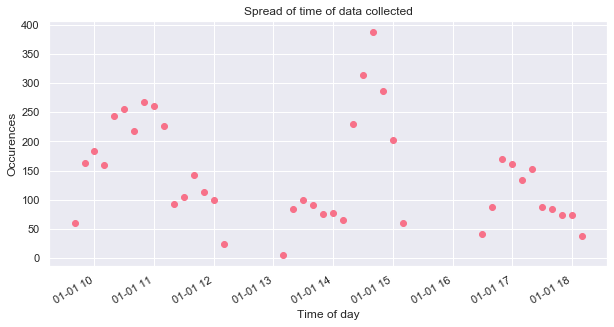

In [89]:
hour_min = [x[11:15] + '0' for x in data['expected_arrival']]
for_aggr = data.assign(hour_min = hour_min)
for_aggr = for_aggr.groupby('hour_min').count().reset_index()

# arrival_datetimes = [dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in data['expected_arrival']]
arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot_date(arrival_times, for_aggr['bus_stop_name'], xdate=True)
ax.set_title("Spread of time of data collected")
ax.set_xlabel("Time of day")
ax.set_ylabel("Occurences")
plt.show()

### Try to see if I can get the average time taken for a bus to travel between "Vauxhall Bus Station" and "Covent Garden Market East Side" (inbound)

In [37]:
vauxhall = data.loc[(data['bus_stop_name'] == 'Vauxhall Bus Station') & (data['direction'] == 'in')]
print(vauxhall.shape)
vauxhall.head()

(61, 5)


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
13,Vauxhall Bus Station,2020-03-11 14:33:35,20196_490000247G1_2020-03-11_in_1,2020-03-11 14:21:20,in
115,Vauxhall Bus Station,2020-03-18 18:05:21,20193_490000247G1_2020-03-18_in_0,2020-03-18 18:05:12,in
162,Vauxhall Bus Station,2020-03-11 10:37:58,20190_490000247G1_2020-03-11_in_0,2020-03-11 10:38:22,in
199,Vauxhall Bus Station,2020-03-11 10:48:58,20283_490000247G1_2020-03-11_in_0,2020-03-11 10:44:06,in
326,Vauxhall Bus Station,2020-03-03 14:11:47,20311_490000247G1_2020-03-03_in_0,2020-03-03 14:01:23,in


In [38]:
covent_garden = data.loc[(data['bus_stop_name'] == 'Covent Garden Market East Side') & (data['direction'] == 'in')]
print(covent_garden.shape)
covent_garden.head()

(61, 5)


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
66,Covent Garden Market East Side,2020-03-03 14:29:47,20280_490005678X_2020-03-03_in_0,2020-03-03 14:29:42,in
320,Covent Garden Market East Side,2020-03-18 17:30:03,20197_490005678X_2020-03-18_in_0,2020-03-18 17:25:33,in
353,Covent Garden Market East Side,2020-03-19 10:36:41,20199_490005678X_2020-03-19_in_0,2020-03-19 10:36:11,in
366,Covent Garden Market East Side,2020-03-03 15:00:01,20202_490005678X_2020-03-03_in_0,2020-03-03 15:00:12,in
422,Covent Garden Market East Side,2020-03-10 11:44:44,20277_490005678X_2020-03-10_in_0,2020-03-10 11:23:00,in


In [42]:
vehicle_id = '20280_490005678X_2020-03-03_in_0'
[bus_id, stop_id, date, direction, num_trip] = vehicle_id.split('_')

bus = covent_garden.loc[covent_garden['vehicle_id'].str.startswith(bus_id, na=False)]
bus = bus.drop(columns = ["direction", "bus_stop_name", "time_of_req"])
print(bus)
same_bus = vauxhall.loc[vauxhall['vehicle_id'].str.startswith(bus_id, na=False)]
same_bus = same_bus.drop(columns = ["direction", "bus_stop_name", "time_of_req"])
print(same_bus)

         expected_arrival                        vehicle_id
66    2020-03-03 14:29:47  20280_490005678X_2020-03-03_in_0
4684  2020-03-10 11:14:59  20280_490005678X_2020-03-10_in_0
5683  2020-03-11 10:58:18  20280_490005678X_2020-03-11_in_0
         expected_arrival                         vehicle_id
3443  2020-03-10 11:17:41  20280_490000247G1_2020-03-10_in_0
4757  2020-03-11 10:59:41  20280_490000247G1_2020-03-11_in_0
4818  2020-03-03 14:31:38  20280_490000247G1_2020-03-03_in_0
